In [3]:
# -------------------------
# Core Python libraries
# -------------------------
import os                      # For file and directory operations
import numpy as np              # Numerical computations
import pandas as pd             # Data manipulation and analysis
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns           # Advanced statistical visualizations

# -------------------------
# Utility libraries
# -------------------------
from pathlib import Path        # Object-oriented file system paths
from collections import Counter # Counting occurrences of elements

# -------------------------
# Scikit-learn preprocessing
# -------------------------
from sklearn.preprocessing import (
    StandardScaler,             # Feature scaling (standardization)
    LabelEncoder                # Encoding categorical labels
)

# -------------------------
# Scikit-learn evaluation metrics
# -------------------------
from sklearn.metrics import (
    accuracy_score,             # Accuracy metric
    f1_score,                   # F1-score metric
    classification_report,      # Precision, recall, F1 detailed report
    confusion_matrix            # Confusion matrix for classification results
)

# -------------------------
# Visualization & reproducibility settings
# -------------------------
sns.set_style("whitegrid")      # Set seaborn plot style
np.random.seed(42)              # Ensure reproducible results


In [4]:
from pathlib import Path

# -------------------------
# Project directory setup
# -------------------------

# Root directory of the project (update if project location changes)
PROJECT_ROOT = Path(r"D:\HAR_PROJECT")

# Path to the dataset folder inside the project
DATA_DIR = PROJECT_ROOT / "data"

# -------------------------
# Sanity checks
# -------------------------

print("PROJECT_ROOT:", PROJECT_ROOT)   # Display project root path
print("DATA_DIR:", DATA_DIR)           # Display data directory path
print("Exists?", DATA_DIR.exists())    # Verify that data directory exists

# -------------------------
# Dataset file discovery
# -------------------------

# Find all subject data files matching pattern: subject*.dat
dat_files = sorted(DATA_DIR.glob("subject*.dat"))

print("Number of subject .dat files:", len(dat_files))  # Total number of files

# Preview first few dataset files
dat_files[:5]


PROJECT_ROOT: D:\HAR_PROJECT
DATA_DIR: D:\HAR_PROJECT\data
Exists? True
Number of subject .dat files: 9


[WindowsPath('D:/HAR_PROJECT/data/subject101.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject102.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject103.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject104.dat'),
 WindowsPath('D:/HAR_PROJECT/data/subject105.dat')]

In [7]:
# -------------------------
# Column names (PAMAP2-style dataset)
# -------------------------

# List of 54 column names matching the PAMAP2 sensor format
PAMAP2_COLS_54 = [
    "timestamp", "activity_id", "heart_rate",

    # -------------------------
    # IMU – Hand sensor
    # -------------------------
    "hand_temp",
    "hand_acc1_x", "hand_acc1_y", "hand_acc1_z",
    "hand_acc2_x", "hand_acc2_y", "hand_acc2_z",
    "hand_gyro_x", "hand_gyro_y", "hand_gyro_z",
    "hand_mag_x", "hand_mag_y", "hand_mag_z",
    "hand_orient_1", "hand_orient_2", "hand_orient_3", "hand_orient_4",

    # -------------------------
    # IMU – Chest sensor
    # -------------------------
    "chest_temp",
    "chest_acc1_x", "chest_acc1_y", "chest_acc1_z",
    "chest_acc2_x", "chest_acc2_y", "chest_acc2_z",
    "chest_gyro_x", "chest_gyro_y", "chest_gyro_z",
    "chest_mag_x", "chest_mag_y", "chest_mag_z",
    "chest_orient_1", "chest_orient_2", "chest_orient_3", "chest_orient_4",

    # -------------------------
    # IMU – Ankle sensor
    # -------------------------
    "ankle_temp",
    "ankle_acc1_x", "ankle_acc1_y", "ankle_acc1_z",
    "ankle_acc2_x", "ankle_acc2_y", "ankle_acc2_z",
    "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
    "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    "ankle_orient_1", "ankle_orient_2", "ankle_orient_3", "ankle_orient_4",
]

# -------------------------
# Activity ID → Activity name mapping
# -------------------------

# Dictionary mapping numeric activity labels to human-readable activity names
ACTIVITY_MAP = {
    1:  "Lying",
    2:  "Sitting",
    3:  "Standing",
    4:  "Walking",
    5:  "Running",
    6:  "Cycling",
    7:  "Nordic walking",
    12: "Ascending stairs",
    13: "Descending stairs",
    16: "Vacuum cleaning",
    17: "Ironing",
    24: "Rope jumping",
}


In [8]:
def load_subject_dat(filepath: Path) -> pd.DataFrame:
    """
    Load a single subject*.dat file from the dataset.
    Automatically handles column-count mismatches safely.
    """
    # -------------------------
    # Read raw .dat file
    # -------------------------

    # PAMAP2 files are space-separated (variable whitespace)
    df = pd.read_csv(filepath, delim_whitespace=True, header=None)

    # -------------------------
    # Assign column names
    # -------------------------

    # If column count matches expected PAMAP2 format
    if df.shape[1] == len(PAMAP2_COLS_54):
        df.columns = PAMAP2_COLS_54
    else:
        # Fallback: assign generic column names
        df.columns = [f"col_{i}" for i in range(df.shape[1])]

        # Attempt to rename first three columns if present
        if df.shape[1] >= 3:
            df = df.rename(columns={
                "col_0": "timestamp",
                "col_1": "activity_id",
                "col_2": "heart_rate"
            })

    # -------------------------
    # Extract subject ID
    # -------------------------

    # Extract numeric subject ID from filename (e.g., subject101.dat → 101)
    sid = int("".join([c for c in filepath.stem if c.isdigit()]))

    # Add subject ID column
    df["subject_id"] = sid

    # Return processed DataFrame
    return df


In [10]:
# -------------------------
# Load and combine subject data
# -------------------------

# Load each subject .dat file into a DataFrame
dfs = [load_subject_dat(f) for f in dat_files]

# Concatenate all subject DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

print("Raw combined shape:", data.shape)                     # Rows × columns after merge
print("Subjects:", sorted(data["subject_id"].unique()))     # List of subject IDs

# -------------------------
# Data cleaning
# -------------------------

# Remove transient / undefined activity class (activity_id == 0)
if "activity_id" in data.columns:
    before = data.shape[0]                                   # Row count before filtering
    data = data[data["activity_id"] != 0].copy()             # Keep valid activity rows only
    print("Removed transient rows:", before - data.shape[0])

# -------------------------
# Activity label mapping
# -------------------------

# Map numeric activity IDs to readable activity names
# Unknown activity IDs are preserved as "ID_xx"
if "activity_id" in data.columns:
    all_ids = sorted(data["activity_id"].dropna().unique())  # Unique activity IDs
    auto_map = {aid: ACTIVITY_MAP.get(aid, f"ID_{aid}") for aid in all_ids}
    data["activity"] = data["activity_id"].map(auto_map)

# -------------------------
# Final dataset summary
# -------------------------

print("Cleaned shape:", data.shape)                           # Final dataset dimensions
print("Num activities:", data["activity"].nunique())          # Number of activity classes

# Preview key columns
data[["timestamp", "activity_id", "activity", "subject_id"]].head()


C:\Users\souga\AppData\Local\Temp\ipykernel_25200\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_25200\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_25200\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=None)
C:\Users\souga\AppData\Local\Temp\ipykernel_25200\705268509.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version.

Raw combined shape: (2872533, 55)
Subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109)]
Removed transient rows: 929661
Cleaned shape: (1942872, 56)
Num activities: 12


,timestamp,activity_id,activity,subject_id
2928,37.66,1,Lying,101
2929,37.67,1,Lying,101
2930,37.68,1,Lying,101
2931,37.69,1,Lying,101
2932,37.70,1,Lying,101


In [11]:
print("Missing values (top 15):")
print(data.isna().sum().sort_values(ascending=False).head(15))

print("\nActivity counts:")
display(data["activity"].value_counts().head(30))


Missing values (top 15):
heart_rate       1765464
hand_temp          11124
hand_acc1_y        11124
hand_acc1_x        11124
hand_acc1_z        11124
hand_acc2_x        11124
hand_acc2_z        11124
hand_acc2_y        11124
hand_orient_1      11124
hand_orient_2      11124
hand_gyro_x        11124
hand_gyro_y        11124
hand_gyro_z        11124
hand_mag_x         11124
hand_mag_y         11124
dtype: int64

Activity counts:


activity
Walking              238761
Ironing              238690
Lying                192523
Standing             189931
Nordic walking       188107
Sitting              185188
Vacuum cleaning      175353
Cycling              164600
Ascending stairs     117216
Descending stairs    104944
Running               98199
Rope jumping          49360
Name: count, dtype: int64

C:\Users\souga\AppData\Local\Temp\ipykernel_25200\3926602751.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


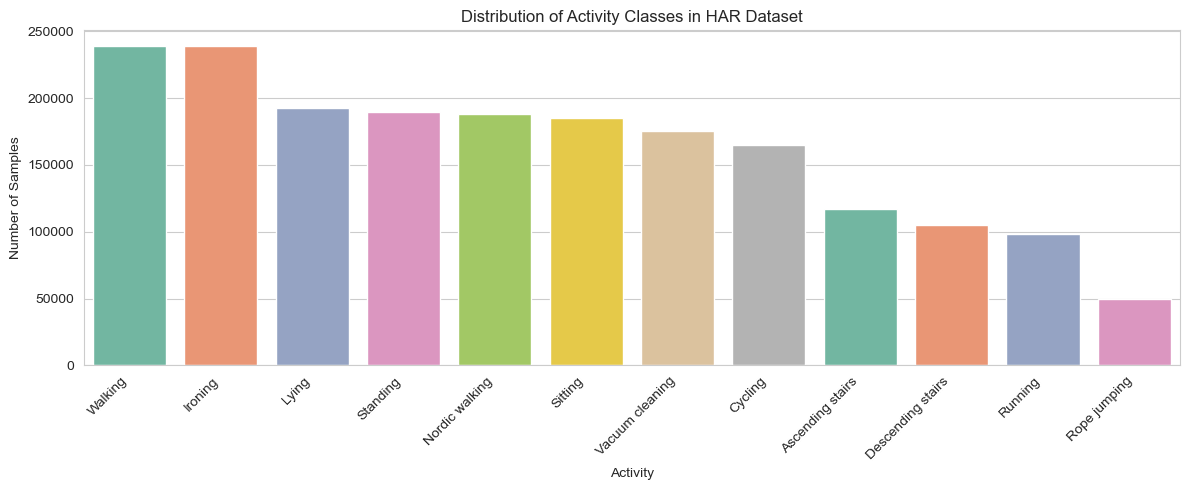

In [12]:
plt.figure(figsize=(12,5))

activity_counts = data["activity"].value_counts()

sns.barplot(
    x=activity_counts.index,
    y=activity_counts.values,
    palette="Set2"   # changed from viridis
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.xlabel("Activity")
plt.title("Distribution of Activity Classes in HAR Dataset")
plt.tight_layout()
plt.show()


In [13]:
# -------------------------
# Select representative accelerometer channels
# -------------------------

# Define accelerometer axes from hand, chest, and ankle sensors
ACC_CHANNELS = [
    "hand_acc1_x", "hand_acc1_y", "hand_acc1_z",
    "chest_acc1_x", "chest_acc1_y", "chest_acc1_z",
    "ankle_acc1_x", "ankle_acc1_y", "ankle_acc1_z",
]

# -------------------------
# Safety check: keep only existing columns
# -------------------------

# Filter channels to include only those present in the dataset
ACC_CHANNELS = [c for c in ACC_CHANNELS if c in data.columns]

# Display final selected accelerometer channels
ACC_CHANNELS


['hand_acc1_x',
 'hand_acc1_y',
 'hand_acc1_z',
 'chest_acc1_x',
 'chest_acc1_y',
 'chest_acc1_z',
 'ankle_acc1_x',
 'ankle_acc1_y',
 'ankle_acc1_z']

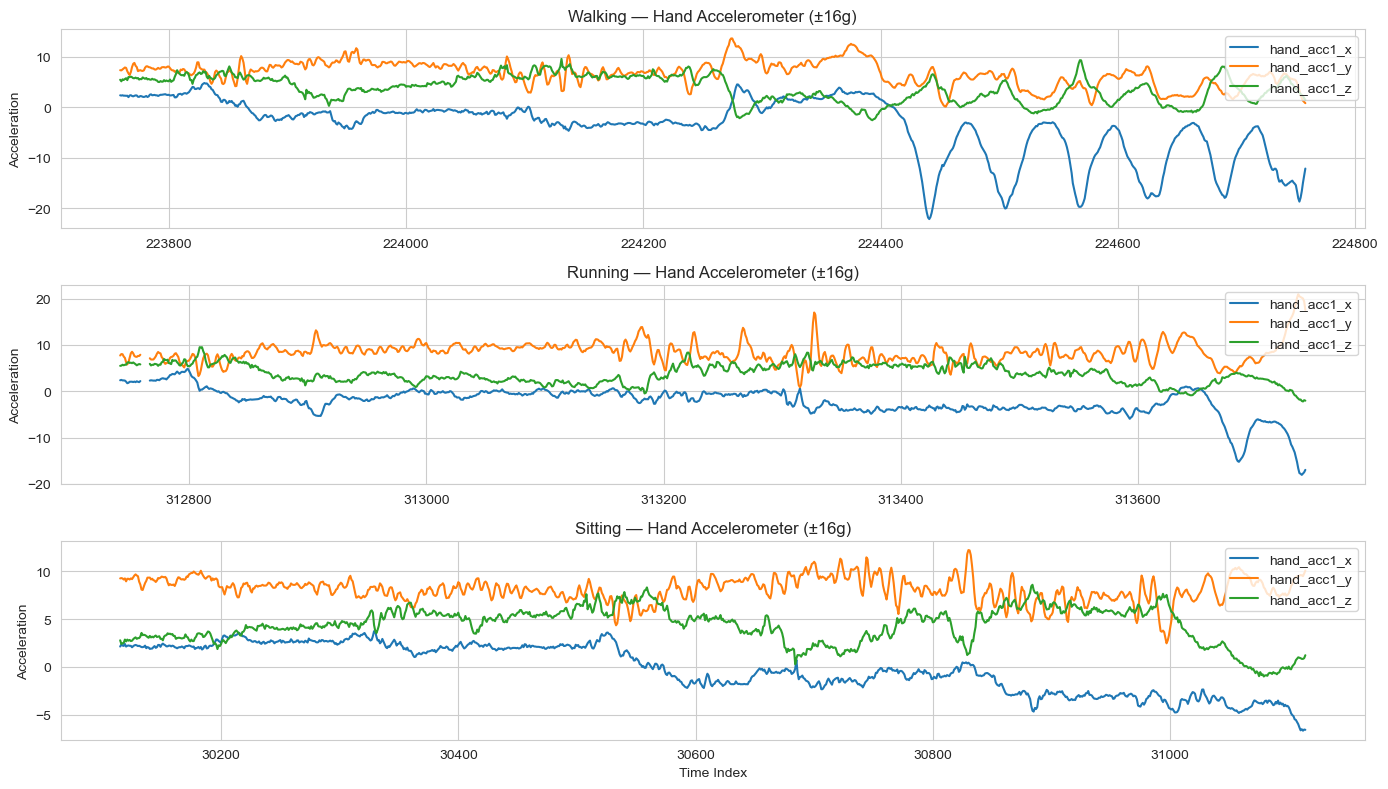

In [14]:
sample_activities = ["Walking", "Running", "Sitting"]

colors = ["tab:blue", "tab:orange", "tab:green"]  # X, Y, Z axes

plt.figure(figsize=(14,8))

for i, act in enumerate(sample_activities):
    act_df = data[data["activity"] == act].iloc[:1000]

    plt.subplot(len(sample_activities), 1, i+1)
    plt.plot(act_df[ACC_CHANNELS[0]], color=colors[0], label=ACC_CHANNELS[0])
    plt.plot(act_df[ACC_CHANNELS[1]], color=colors[1], label=ACC_CHANNELS[1])
    plt.plot(act_df[ACC_CHANNELS[2]], color=colors[2], label=ACC_CHANNELS[2])

    plt.title(f"{act} — Hand Accelerometer (±16g)")
    plt.ylabel("Acceleration")
    plt.legend(loc="upper right")

plt.xlabel("Time Index")
plt.tight_layout()
plt.show()


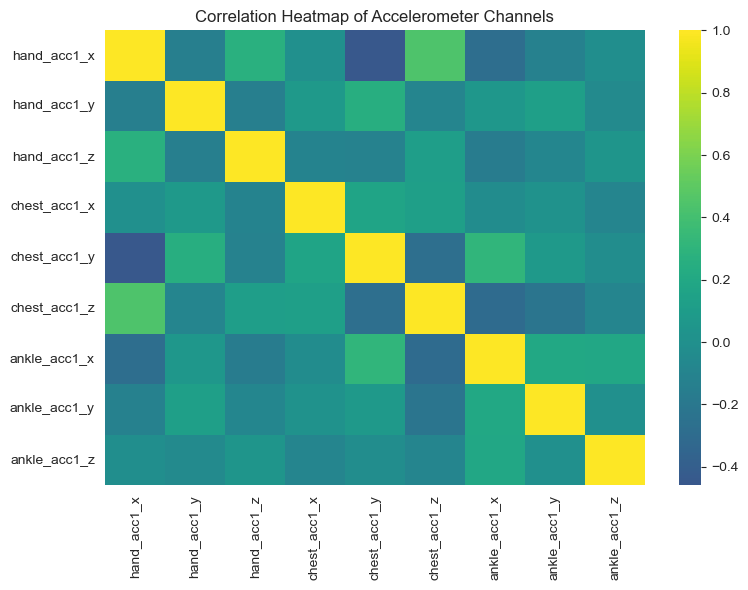

In [15]:
# Use a small subset for speed
corr_df = data[ACC_CHANNELS].dropna().sample(3000, random_state=42)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_df.corr(),
    cmap="viridis",   # changed color map
    center=0
)
plt.title("Correlation Heatmap of Accelerometer Channels")
plt.tight_layout()
plt.show()


In [17]:
# -------------------------
# Missing value analysis
# -------------------------

# Count missing values per column and sort in descending order
missing_summary = (
    data.isna()                      # Boolean mask of missing values
    .sum()                           # Count missing values per column
    .sort_values(ascending=False)    # Sort columns by missing count
)

# Display top 15 columns with the most missing values
missing_summary.head(15)


heart_rate       1765464
hand_temp          11124
hand_acc1_y        11124
hand_acc1_x        11124
hand_acc1_z        11124
hand_acc2_x        11124
hand_acc2_z        11124
hand_acc2_y        11124
hand_orient_1      11124
hand_orient_2      11124
hand_gyro_x        11124
hand_gyro_y        11124
hand_gyro_z        11124
hand_mag_x         11124
hand_mag_y         11124
dtype: int64

In [19]:
sensor_cols = [
    c for c in data.columns
    if c not in ["timestamp", "activity", "activity_id", "subject_id"]
]

data[sensor_cols] = (
    data
    .groupby("subject_id")[sensor_cols]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

print("Remaining NaNs after sensor fill:", data.isna().sum().sum())


Remaining NaNs after sensor fill: 0


In [20]:
# -------------------------
# Encode activity labels
# -------------------------

# Initialize label encoder for categorical activity names
le = LabelEncoder()

# Convert activity names to numeric class labels
data["activity_label"] = le.fit_transform(data["activity"])

# -------------------------
# Display encoding mapping
# -------------------------

print("Encoded classes:")
for i, cls in enumerate(le.classes_):
    print(i, "→", cls)   # Mapping: numeric label → activity name


Encoded classes:
0 → Ascending stairs
1 → Cycling
2 → Descending stairs
3 → Ironing
4 → Lying
5 → Nordic walking
6 → Rope jumping
7 → Running
8 → Sitting
9 → Standing
10 → Vacuum cleaning
11 → Walking


In [21]:
# -------------------------
# Remove orientation-related features
# -------------------------

# Identify all orientation columns (e.g., quaternion / orientation data)
orientation_cols = [c for c in data.columns if "orient" in c.lower()]

# Drop orientation channels from the dataset
data = data.drop(columns=orientation_cols)

print("Dropped orientation columns:", len(orientation_cols))  # Number of removed columns

# -------------------------
# Define final feature set
# -------------------------

# Select raw sensor signal columns as features
# Exclude metadata and label-related columns
FEATURE_COLS = [
    c for c in data.columns
    if c not in [
        "timestamp",
        "activity",
        "activity_id",
        "activity_label",
        "subject_id"
    ]
]

# Display feature count and preview first few feature names
len(FEATURE_COLS), FEATURE_COLS[:10]


Dropped orientation columns: 12


(40,
 ['heart_rate',
  'hand_temp',
  'hand_acc1_x',
  'hand_acc1_y',
  'hand_acc1_z',
  'hand_acc2_x',
  'hand_acc2_y',
  'hand_acc2_z',
  'hand_gyro_x',
  'hand_gyro_y'])

In [22]:
# -------------------------
# Final data integrity checks
# -------------------------

# Ensure no missing values remain in the dataset
assert data.isna().sum().sum() == 0, "❌ NaNs still exist!"

# Verify that multiple subjects are present
assert data["subject_id"].nunique() >= 2, "❌ Subject info corrupted!"

# Verify that multiple activity classes exist
assert data["activity_label"].nunique() >= 2, "❌ Labels corrupted!"

# Confirmation message if all checks pass
print("✅ Data preprocessing checks passed")


✅ Data preprocessing checks passed


In [23]:
# Subjects present
subjects = sorted(data["subject_id"].unique())
subjects


[np.int64(101),
 np.int64(102),
 np.int64(103),
 np.int64(104),
 np.int64(105),
 np.int64(106),
 np.int64(107),
 np.int64(108),
 np.int64(109)]

In [24]:
# -------------------------
# Manual subject-wise dataset split
# -------------------------

# Split subjects to avoid data leakage between train, validation, and test sets
# 60% → training, 20% → validation, 20% → testing
# (Adjust ratios if the dataset has a different number of subjects)

train_subjects = subjects[:int(0.6 * len(subjects))]
val_subjects   = subjects[int(0.6 * len(subjects)) : int(0.8 * len(subjects))]
test_subjects  = subjects[int(0.8 * len(subjects)) :]

# Display subject allocation for each split
print("Train subjects:", train_subjects)
print("Val subjects  :", val_subjects)
print("Test subjects :", test_subjects)


Train subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105)]
Val subjects  : [np.int64(106), np.int64(107)]
Test subjects : [np.int64(108), np.int64(109)]


In [25]:
# -------------------------
# Create train / validation / test datasets
# -------------------------

# Select samples belonging to training subjects
train_df = data[data["subject_id"].isin(train_subjects)].copy()

# Select samples belonging to validation subjects
val_df   = data[data["subject_id"].isin(val_subjects)].copy()

# Select samples belonging to testing subjects
test_df  = data[data["subject_id"].isin(test_subjects)].copy()

# -------------------------
# Verify dataset sizes
# -------------------------

print("Train shape:", train_df.shape)   # Training set dimensions
print("Val shape  :", val_df.shape)     # Validation set dimensions
print("Test shape :", test_df.shape)    # Test set dimensions


Train shape: (1191507, 45)
Val shape  : (482872, 45)
Test shape : (268493, 45)


In [26]:
def create_windows(df, feature_cols, label_col,
                   window_size=256, overlap=0.5):
    """
    Create sliding windows from a dataframe.
    Returns X (windows), y (labels).
    """
    step = int(window_size * (1 - overlap))
    
    X, y = [], []
    
    for sid in df["subject_id"].unique():
        sub_df = df[df["subject_id"] == sid]
        
        X_sub = sub_df[feature_cols].values
        y_sub = sub_df[label_col].values
        # -------------------------
# Sliding window parameters
# -------------------------

# Number of time steps per window
WINDOW_SIZE = 256

# Fraction of overlap between consecutive windows (50%)
OVERLAP = 0.5

# -------------------------
# Create sliding windows for each split
# -------------------------

# Generate training windows and labels
X_train, y_train = create_windows(
    train_df,
    FEATURE_COLS,
    "activity_label",
    window_size=WINDOW_SIZE,
    overlap=OVERLAP
)

# Generate validation windows and labels
X_val, y_val = create_windows(
    val_df,
    FEATURE_COLS,
    "activity_label",
    window_size=WINDOW_SIZE,
    overlap=OVERLAP
)

# Generate test windows and labels
X_test, y_test = create_windows(
    test_df,
    FEATURE_COLS,
    "activity_label",
    window_size=WINDOW_SIZE,
    overlap=OVERLAP
)

        for start in range(0, len(sub_df) - window_size, step):
            end = start + window_size
            
            window_x = X_sub[start:end]
            window_y = y_sub[start:end]
            
            # Majority vote
            label = np.bincount(window_y).argmax()
            
            X.append(window_x)
            y.append(label)
    
    return np.array(X), np.array(y)


In [28]:
# -------------------------
# Verify windowed dataset shapes
# -------------------------

# Training set dimensions
print("X_train:", X_train.shape)   # (num_windows, window_size, num_features)
print("y_train:", y_train.shape)   # (num_windows,)

# Validation set dimensions
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

# Test set dimensions
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train: (9301, 256, 40)
y_train: (9301,)
X_val  : (3769, 256, 40)
y_val  : (3769,)
X_test : (2094, 256, 40)
y_test : (2094,)


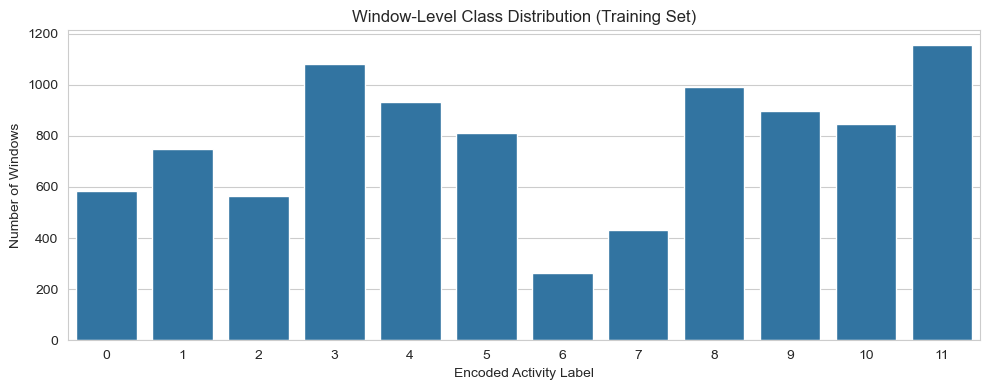

In [29]:
plt.figure(figsize=(10,4))
sns.countplot(x=y_train)
plt.title("Window-Level Class Distribution (Training Set)")
plt.xlabel("Encoded Activity Label")
plt.ylabel("Number of Windows")
plt.tight_layout()
plt.show()


In [30]:
# -------------------------
# Verify subject-wise data separation
# -------------------------

# Ensure no subject appears in both training and test sets
assert set(train_subjects).isdisjoint(test_subjects)

# Ensure no subject appears in both training and validation sets
assert set(train_subjects).isdisjoint(val_subjects)

# Ensure no subject appears in both validation and test sets
assert set(val_subjects).isdisjoint(test_subjects)

# Confirmation message if no data leakage is detected
print("✅ Subject-wise separation verified (no leakage)")


✅ Subject-wise separation verified (no leakage)


In [31]:
# -------------------------
# Feature normalization (standardization)
# -------------------------

# Number of features per time step
num_features = X_train.shape[2]

# Initialize standard scaler (zero mean, unit variance)
scaler = StandardScaler()

# -------------------------
# Fit scaler on training data only
# -------------------------

# Flatten training windows to 2D for scaler fitting
X_train_reshaped = X_train.reshape(-1, num_features)

# Learn scaling parameters from training data
scaler.fit(X_train_reshaped)

# -------------------------
# Apply normalization to all splits
# -------------------------

def normalize_windows(X, scaler):
    """
    Normalize windowed data using a fitted scaler.
    """
    # Flatten windows for transformation
    X_flat = X.reshape(-1, X.shape[2])
    
    # Apply scaling
    X_norm = scaler.transform(X_flat)
    
    # Restore original window shape
    return X_norm.reshape(X.shape)

# Normalize training, validation, and test sets
X_train_norm = normalize_windows(X_train, scaler)
X_val_norm   = normalize_windows(X_val, scaler)
X_test_norm  = normalize_windows(X_test, scaler)

# Confirmation message
print("✅ Normalization complete")


✅ Normalization complete


In [32]:
# -------------------------
# Verify normalization statistics
# -------------------------

# Mean of normalized training data (should be close to 0)
print("Train mean (≈0):", X_train_norm.mean())

# Standard deviation of normalized training data (should be close to 1)
print("Train std  (≈1):", X_train_norm.std())


Train mean (≈0): -3.4501108859173524e-14
Train std  (≈1): 0.9999999999994846


In [33]:
# -------------------------
# Data augmentation functions
# -------------------------

def add_gaussian_noise(X, std=0.01):
    """
    Add Gaussian noise to sensor signals to improve model robustness.
    """
    # Generate noise with zero mean and specified standard deviation
    noise = np.random.normal(0, std, X.shape)
    
    # Add noise to the original signal
    return X + noise


def magnitude_scaling(X, scale_range=(0.9, 1.1)):
    """
    Apply random magnitude scaling to sensor signals.
    """
    # Sample a random scaling factor within the given range
    scale = np.random.uniform(scale_range[0], scale_range[1])
    
    # Scale the signal magnitude
    return X * scale


In [34]:
# -------------------------
# Apply data augmentation to training set
# -------------------------

# Combine original, noise-augmented, and scaled training windows
X_train_aug = np.concatenate([
    X_train_norm,                      # Original normalized data
    add_gaussian_noise(X_train_norm),  # Gaussian noise augmentation
    magnitude_scaling(X_train_norm)    # Magnitude scaling augmentation
])

# Duplicate labels to match augmented samples
y_train_aug = np.concatenate([
    y_train,  # Original labels
    y_train,  # Labels for noise-augmented data
    y_train   # Labels for scaled data
])

# -------------------------
# Verify augmentation effect
# -------------------------

print("Original train windows:", X_train_norm.shape[0])
print("Augmented train windows:", X_train_aug.shape[0])


Original train windows: 9301
Augmented train windows: 27903


In [37]:
# -------------------------
# Statistical feature extraction
# -------------------------

def extract_stat_features(X):
    """
    Extract statistical features from windowed sensor data.
    
    Input shape : (num_samples, window_size, num_features)
    Output shape: (num_samples, num_features * 6)
    """
    features = []  # List to store feature vectors for each window
    
    # Iterate over each window
    for win in X:
        feat = []  # Feature vector for the current window
        
        # Mean of each feature across time
        feat.extend(win.mean(axis=0))
        
        # Standard deviation of each feature
        feat.extend(win.std(axis=0))
        
        # Minimum value of each feature
        feat.extend(win.min(axis=0))
        
        # Maximum value of each feature
        feat.extend(win.max(axis=0))
        
        # Median value of each feature
        feat.extend(np.median(win, axis=0))
        
        # Peak-to-peak value (max - min) of each feature
        feat.extend(np.ptp(win, axis=0))
        
        # Append feature vector for this window
        features.append(feat)
        
    # Convert list of feature vectors to NumPy array
    return np.array(features)


In [38]:
# -------------------------
# Extract statistical features for ML models
# -------------------------

# Extract features from normalized training windows
X_train_ml = extract_stat_features(X_train_norm)

# Extract features from normalized validation windows
X_val_ml   = extract_stat_features(X_val_norm)

# Extract features from normalized test windows
X_test_ml  = extract_stat_features(X_test_norm)

# Display feature matrix shape (samples × extracted features)
print("ML feature shape:", X_train_ml.shape)


ML feature shape: (9301, 240)


In [39]:
# -------------------------
# Compute class weights for imbalance handling
# -------------------------

from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights based on training labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to dictionary format (label → weight)
class_weight_dict = dict(enumerate(class_weights))

# Display class weights
class_weight_dict


{0: np.float64(1.3294739851343624),
 1: np.float64(1.0362076648841354),
 2: np.float64(1.3694051825677267),
 3: np.float64(0.7163431916204559),
 4: np.float64(0.831634477825465),
 5: np.float64(0.9568930041152264),
 6: np.float64(2.9583333333333335),
 7: np.float64(1.798337200309358),
 8: np.float64(0.7829124579124579),
 9: np.float64(0.8650483630952381),
 10: np.float64(0.9161741528762806),
 11: np.float64(0.671067821067821)}

In [64]:
# -------------------------
# Core scientific libraries
# -------------------------

import numpy as np                 # Numerical computing
import pandas as pd                # Data manipulation and analysis

from collections import Counter    # Frequency counting utilities

# -------------------------
# Scikit-learn preprocessing & metrics
# -------------------------

from sklearn.preprocessing import (
    LabelEncoder,                  # Encode categorical labels
    StandardScaler                 # Feature standardization
)

from sklearn.metrics import (
    accuracy_score,                # Classification accuracy
    f1_score,                      # F1-score (balance of precision & recall)
    classification_report,         # Detailed classification metrics
    confusion_matrix,              # Confusion matrix
    ConfusionMatrixDisplay         # Confusion matrix visualization
)

# -------------------------
# LightGBM (gradient boosting)
# -------------------------

import lightgbm as lgb              # LightGBM framework
from lightgbm import (
    early_stopping,                # Early stopping callback
    log_evaluation,                # Logging during training
    record_evaluation              # Record evaluation metrics
)

# -------------------------
# Visualization libraries
# -------------------------

import matplotlib.pyplot as plt     # Plotting
import seaborn as sns               # Statistical visualizations

# -------------------------
# Signal processing & statistics
# -------------------------

from scipy.stats import skew, kurtosis  # Higher-order statistical features
from scipy.fftpack import fft           # Fast Fourier Transform


In [65]:
# -------------------------
# Select raw sensor feature columns
# -------------------------

# Collect all sensor feature columns
# Exclude metadata and label-related columns
feature_cols = [
    c for c in train_df.columns
    if c not in ["timestamp", "activity", "activity_id", "subject_id"]
]

# Display total number of selected raw features
print("Number of raw features:", len(feature_cols))


Number of raw features: 41


In [66]:
WINDOW_SIZE = 256
STEP_SIZE   = 64


In [67]:
# -------------------------
# Create sliding windows for raw sensor features
# -------------------------

# Generate windowed training data and activity labels
X_train, y_train = create_windows(
    train_df,
    feature_cols,
    "activity",
    WINDOW_SIZE,
    STEP_SIZE
)

# Generate windowed validation data and activity labels
X_val, y_val = create_windows(
    val_df,
    feature_cols,
    "activity",
    WINDOW_SIZE,
    STEP_SIZE
)

# Generate windowed test data and activity labels
X_test, y_test = create_windows(
    test_df,
    feature_cols,
    "activity",
    WINDOW_SIZE,
    STEP_SIZE
)

# -------------------------
# Verify windowed data shapes
# -------------------------

print("Window shapes:")
print("Train:", X_train.shape)   # (num_windows, window_size, num_features)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Window shapes:
Train: (18361, 256, 41)
Val  : (7438, 256, 41)
Test : (4136, 256, 41)


In [68]:
import numpy as np
from scipy.stats import skew, kurtosis

# -------------------------
# Time–frequency feature extraction
# -------------------------

def extract_features(X):
    """
    Extract time-domain and frequency-domain features from windowed data.
    
    Input shape : (num_samples, window_size, num_features)
    Output shape: (num_samples, extracted_features)
    """
    feats = []  # Store feature vectors for all windows

    # Iterate over each sliding window
    for w in X:
        f = []  # Feature vector for the current window

        # -------------------------
        # Time-domain features
        # -------------------------

        # Mean of each sensor channel
        f.extend(np.mean(w, axis=0))

        # Standard deviation of each sensor channel
        f.extend(np.std(w, axis=0))

        # Minimum value of each sensor channel
        f.extend(np.min(w, axis=0))

        # Maximum value of each sensor channel
        f.extend(np.max(w, axis=0))

        # Skewness (asymmetry of signal distribution)
        f.extend(skew(w, axis=0))

        # Kurtosis (tailedness of signal distribution)
        f.extend(kurtosis(w, axis=0))

        # -------------------------
        # Frequency-domain features
        # -------------------------

        # Magnitude of FFT (real-valued FFT)
        fft_vals = np.abs(np.fft.rfft(w, axis=0))

        # Mean of FFT magnitudes
        f.extend(np.mean(fft_vals, axis=0))

        # Standard deviation of FFT magnitudes
        f.extend(np.std(fft_vals, axis=0))

        # Append feature vector for this window
        feats.append(f)

    # Convert list of feature vectors to NumPy array
    return np.array(feats)


In [69]:
# -------------------------
# Extract engineered features for ML models
# -------------------------

# Extract features from training windows
X_train_feat = extract_features(X_train)

# Extract features from validation windows
X_val_feat   = extract_features(X_val)

# Extract features from test windows
X_test_feat  = extract_features(X_test)

# Display feature matrix shapes for each split
print(X_train_feat.shape, X_val_feat.shape, X_test_feat.shape)


C:\Users\souga\AppData\Local\Temp\ipykernel_30388\2657124984.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f.extend(skew(w, axis=0))
C:\Users\souga\AppData\Local\Temp\ipykernel_30388\2657124984.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f.extend(kurtosis(w, axis=0))


(18361, 328) (7438, 328) (4136, 328)


In [70]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)


Classes: ['Ascending stairs' 'Cycling' 'Descending stairs' 'Ironing' 'Lying'
 'Nordic walking' 'Rope jumping' 'Running' 'Sitting' 'Standing'
 'Vacuum cleaning' 'Walking']


In [72]:
import numpy as np

# -------------------------
# Check for invalid values in extracted features
# -------------------------

# Count NaN values in training feature matrix
print("NaNs in train:", np.isnan(X_train_feat).sum())

# Count infinite values in training feature matrix
print("Infs in train:", np.isinf(X_train_feat).sum())


NaNs in train: 122682
Infs in train: 0


In [73]:
# -------------------------
# Handle NaN and infinite values
# -------------------------

# Replace NaN and ±Inf values with zeros in training features
X_train_feat = np.nan_to_num(
    X_train_feat,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)

# Replace NaN and ±Inf values with zeros in validation features
X_val_feat = np.nan_to_num(
    X_val_feat,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)

# Replace NaN and ±Inf values with zeros in test features
X_test_feat = np.nan_to_num(
    X_test_feat,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)


In [74]:
# -------------------------
# Low-variance feature removal
# -------------------------

from sklearn.feature_selection import VarianceThreshold

# Initialize variance threshold to remove near-constant features
vt = VarianceThreshold(threshold=1e-6)

# Fit on training data and remove low-variance features
X_train_feat = vt.fit_transform(X_train_feat)

# Apply the same feature selection to validation data
X_val_feat   = vt.transform(X_val_feat)

# Apply the same feature selection to test data
X_test_feat  = vt.transform(X_test_feat)

# Display remaining number of features
print("Features after variance filtering:", X_train_feat.shape[1])


Features after variance filtering: 325


In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_ml = scaler.fit_transform(X_train_feat)
X_val_ml   = scaler.transform(X_val_feat)
X_test_ml  = scaler.transform(X_test_feat)


In [77]:
from collections import Counter
import numpy as np

# -------------------------
# Manually compute class weights
# -------------------------

# Count number of samples per class in training labels
counts = Counter(y_train_enc)

# Total number of training samples
total = sum(counts.values())

# Compute inverse-frequency class weights
# Weight = total_samples / (num_classes × class_samples)
class_weight = {
    cls: total / (len(counts) * cnt)
    for cls, cnt in counts.items()
}

# Display computed class weights
class_weight


{np.int64(4): 0.8275193798449613,
 np.int64(8): 0.7794617082696553,
 np.int64(9): 0.863965744400527,
 np.int64(3): 0.7129931655793724,
 np.int64(10): 0.9140282755874154,
 np.int64(0): 1.360074074074074,
 np.int64(2): 1.4076203618521925,
 np.int64(11): 0.667867015859159,
 np.int64(5): 0.9533229491173416,
 np.int64(1): 1.0317487075747358,
 np.int64(7): 1.8000980392156862,
 np.int64(6): 2.9595422308188266}

In [78]:
import lightgbm as lgb

# -------------------------
# LightGBM multiclass classifier
# -------------------------

lgb_model = lgb.LGBMClassifier(
    objective="multiclass",          # Multiclass classification objective
    num_class=len(le.classes_),      # Number of activity classes
    n_estimators=1200,               # Total number of boosting iterations
    learning_rate=0.03,              # Step size shrinkage
    num_leaves=128,                  # Maximum number of leaves per tree
    max_depth=-1,                    # No depth limit (controlled by num_leaves)
    subsample=0.9,                   # Row sampling for each tree
    colsample_bytree=0.9,            # Feature sampling for each tree
    class_weight=class_weight,       # Handle class imbalance
    random_state=42,                 # Reproducibility
    n_jobs=-1                        # Use all available CPU cores
)
lgb_model.fit(
    X_train_ml,
    y_train_enc,
    eval_set=[(X_val_ml, y_val_enc)],
    eval_metric="multi_logloss"
)




In [80]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------
# Model evaluation on test set
# -------------------------

# Generate predictions for test features
y_pred = lgb_model.predict(X_test_ml)

# Compute overall classification accuracy
acc = accuracy_score(y_test_enc, y_pred)

# Compute macro-averaged F1 score (treats all classes equally)
f1  = f1_score(y_test_enc, y_pred, average="macro")

# Display evaluation metrics
print("LightGBM Test Accuracy:", acc)
print("LightGBM Macro F1     :", f1)

# -------------------------
# Detailed classification report
# -------------------------

print("\nClassification Report:\n")
print(classification_report(
    y_test_enc,              # True labels
    y_pred,                  # Predicted labels
    target_names=le.classes_ # Class names
))


C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Test Accuracy: 0.9941972920696325
LightGBM Macro F1     : 0.9920588952131922

Classification Report:

                   precision    recall  f1-score   support

 Ascending stairs       1.00      1.00      1.00       176
          Cycling       1.00      1.00      1.00       394
Descending stairs       1.00      1.00      1.00       142
          Ironing       1.00      1.00      1.00       512
            Lying       1.00      1.00      1.00       374
   Nordic walking       0.99      1.00      0.99       447
     Rope jumping       0.94      0.96      0.95       230
          Running       0.98      0.94      0.96       254
          Sitting       1.00      1.00      1.00       354
         Standing       1.00      1.00      1.00       389
  Vacuum cleaning       1.00      1.00      1.00       375
          Walking       1.00      1.00      1.00       489

         accuracy                           0.99      4136
        macro avg       0.99      0.99      0.99      4136
  

C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


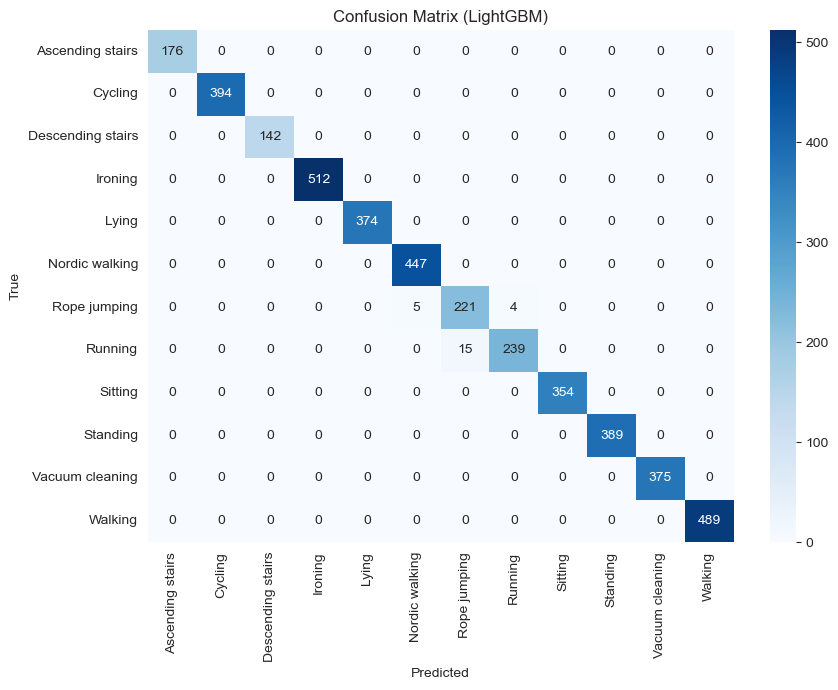

In [81]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------
# Model evaluation on test set
# -------------------------

# Generate predictions for test features
y_pred = lgb_model.predict(X_test_ml)

# Compute overall classification accuracy
acc = accuracy_score(y_test_enc, y_pred)

# Compute macro-averaged F1 score (treats all classes equally)
f1  = f1_score(y_test_enc, y_pred, average="macro")

# Display evaluation metrics
print("LightGBM Test Accuracy:", acc)
print("LightGBM Macro F1     :", f1)

# -------------------------
# Detailed classification report
# -------------------------

print("\nClassification Report:\n")
print(classification_report(
    y_test_enc,              # True labels
    y_pred,                  # Predicted labels
    target_names=le.classes_ # Class names
))


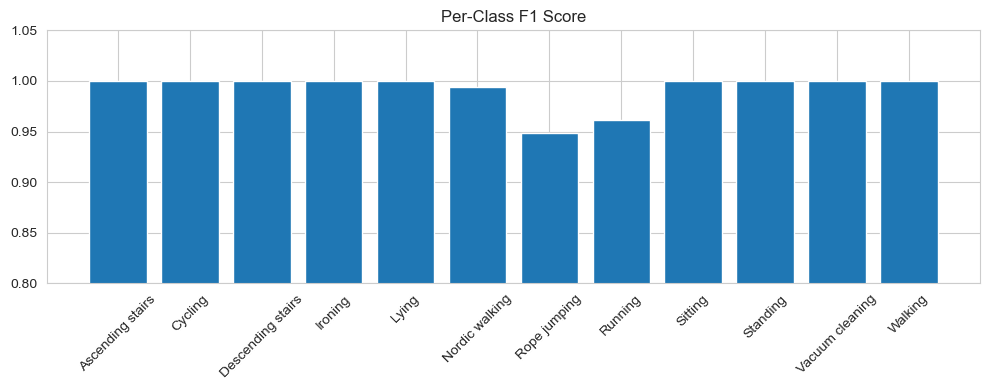

In [83]:
from sklearn.metrics import f1_score

# -------------------------
# Per-class F1-score analysis
# -------------------------

# Compute F1 score for each class individually
f1_per_class = f1_score(y_test_enc, y_pred, average=None)

# Plot per-class F1 scores
plt.figure(figsize=(10,4))
plt.bar(le.classes_, f1_per_class)
plt.xticks(rotation=45)
plt.ylim(0.8, 1.05)
plt.title("Per-Class F1 Score")
plt.tight_layout()
plt.show()


In [88]:
# -------------------------
# Train LightGBM model with evaluation tracking
# -------------------------

# Dictionary to store evaluation metrics during training
evals_result = {}

# Fit the LightGBM model
lgb_model.fit(
    X_train_ml,
    y_train_enc,
    eval_set=[(X_train_ml, y_train_enc), (X_val_ml, y_val_enc)],  # Train & validation sets
    eval_metric="multi_logloss",                                  # Multiclass log loss
    eval_names=["train", "val"],                                  # Names for eval datasets
    callbacks=[
        lgb.record_evaluation(evals_result)                       # Store metrics per iteration
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79893
[LightGBM] [Info] Number of data points in the train set: 18361, number of used features: 325
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, be

,boosting_type,'gbdt'
,num_leaves,128
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,"{np.int64(0): 1.360074074074074, np.int64(1): 1.0317487075747358, np.int64(2): 1.4076203618521925, np.int64(3): 0.7129931655793724, ...}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


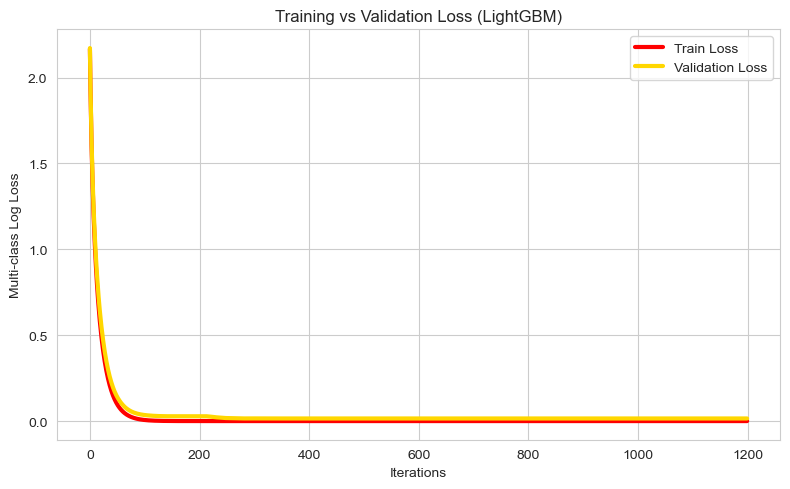

In [89]:
import matplotlib.pyplot as plt

train_loss = evals_result["train"]["multi_logloss"]
val_loss   = evals_result["val"]["multi_logloss"]

plt.figure(figsize=(8, 5))

plt.plot(
    train_loss,
    label="Train Loss",
    color="red",
    linewidth=3
)

plt.plot(
    val_loss,
    label="Validation Loss",
    color="gold",
    linewidth=3
)

plt.xlabel("Iterations")
plt.ylabel("Multi-class Log Loss")
plt.title("Training vs Validation Loss (LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [115]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU,
    MaxPooling1D, GlobalAveragePooling1D, Dropout
)

# -------------------------
# CNN-based feature extractor
# -------------------------

def build_cnn_feature_extractor(input_shape):
    """
    Build a 1D CNN feature extractor for time-series sensor data.
    
    Input shape : (window_size, num_features)
    Output      : Learned feature vector
    """
    # Input layer
    inp = Input(shape=input_shape)

    # -------------------------
    # Convolutional block 1
    # -------------------------
    x = Conv1D(64, 7, padding="same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    # -------------------------
    # Convolutional block 2
    # -------------------------
    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    # -------------------------
    # Convolutional block 3
    # -------------------------
    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # -------------------------
    # Global pooling & regularization
    # -------------------------
    x = GlobalAveragePooling1D()(x)  # Convert time dimension to feature vector
    x = Dropout(0.3)(x)              # Reduce overfitting

    # Return feature extractor model
    return Model(inp, x, name="CNN_Feature_Extractor")


In [116]:
# -------------------------
# Initialize CNN feature extractor
# -------------------------

# Build CNN feature extractor using training window shape
cnn_feature_model = build_cnn_feature_extractor(
    input_shape=X_train.shape[1:]   # (window_size, num_features)
)

# -------------------------
# Compile model
# -------------------------

# Compile with MSE loss (unsupervised / feature learning setup)
cnn_feature_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  # Adam optimizer
    loss="mse"
)

# Display model architecture summary
cnn_feature_model.summary()


Model: "CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 41)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 256, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,872 (624.50 KB)

 Trainable params: 158,976 (621.00 KB)

 Non-trainable params: 896 (3.50 KB)

In [118]:
# -------------------------
# Extract CNN-based features
# -------------------------

# Generate CNN feature embeddings for training data
X_train_cnn = cnn_feature_model.predict(X_train, batch_size=128)

# Generate CNN feature embeddings for validation data
X_val_cnn   = cnn_feature_model.predict(X_val, batch_size=128)

# Generate CNN feature embeddings for test data
X_test_cnn  = cnn_feature_model.predict(X_test, batch_size=128)

# -------------------------
# Verify CNN feature dimensions
# -------------------------

print("CNN Feature Shapes:")
print(X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
CNN Feature Shapes:
(18361, 256) (7438, 256) (4136, 256)


In [119]:
import numpy as np

# -------------------------
# Create hybrid feature representation
# -------------------------

# Concatenate handcrafted statistical features with CNN-extracted features
X_train_hybrid = np.hstack([X_train_feat, X_train_cnn])
X_val_hybrid   = np.hstack([X_val_feat, X_val_cnn])
X_test_hybrid  = np.hstack([X_test_feat, X_test_cnn])

# Display final hybrid feature dimensionality
print("Hybrid Feature Shape:", X_train_hybrid.shape)


Hybrid Feature Shape: (18361, 581)


In [120]:
import lightgbm as lgb

# -------------------------
# LightGBM classifier on hybrid features
# -------------------------

# Initialize LightGBM model using hybrid (statistical + CNN) features
lgb_hybrid = lgb.LGBMClassifier(
    objective="multiclass",          # Multiclass classification
    num_class=len(le.classes_),      # Number of activity classes
    n_estimators=1200,               # Number of boosting trees
    learning_rate=0.03,              # Learning rate
    num_leaves=128,                  # Tree complexity control
    max_depth=-1,                    # Unlimited depth (controlled by num_leaves)
    subsample=0.8,                   # Row subsampling
    colsample_bytree=0.8,            # Feature subsampling
    class_weight="balanced",         # Automatic class imbalance handling
    random_state=42,                 # Reproducibility
    n_jobs=-1                        # Use all CPU cores
)

# -------------------------
# Train hybrid model
# -------------------------

lgb_hybrid.fit(
    X_train_hybrid,
    y_train_enc,
    eval_set=[(X_val_hybrid, y_val_enc)],  # Validation monitoring
    eval_metric="multi_logloss"             # Multiclass log loss
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139793
[LightGBM] [Info] Number of data points in the train set: 18361, number of used features: 570
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, b

,boosting_type,'gbdt'
,num_leaves,128
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [121]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -------------------------
# Evaluate hybrid LightGBM model on test set
# -------------------------

# Generate predictions using hybrid feature representation
y_pred_hybrid = lgb_hybrid.predict(X_test_hybrid)

# Compute overall test accuracy
acc_hybrid = accuracy_score(y_test_enc, y_pred_hybrid)

# Compute macro-averaged F1 score (equal importance to all classes)
f1_hybrid  = f1_score(y_test_enc, y_pred_hybrid, average="macro")

# Display evaluation metrics
print("Hybrid Test Accuracy :", acc_hybrid)
print("Hybrid Macro F1      :", f1_hybrid)

# -------------------------
# Detailed per-class performance
# -------------------------

print("\nClassification Report:")
print(classification_report(
    y_test_enc,                # True labels
    y_pred_hybrid,             # Predicted labels
    target_names=le.classes_   # Activity class names
))


C:\Users\souga\anaconda3\envs\har-ml-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hybrid Test Accuracy : 0.9927466150870407
Hybrid Macro F1      : 0.9909846666489771

Classification Report:
                   precision    recall  f1-score   support

 Ascending stairs       1.00      1.00      1.00       176
          Cycling       1.00      1.00      1.00       394
Descending stairs       1.00      1.00      1.00       142
          Ironing       1.00      1.00      1.00       512
            Lying       0.98      0.99      0.98       374
   Nordic walking       0.98      1.00      0.99       447
     Rope jumping       1.00      0.89      0.94       230
          Running       0.97      0.99      0.98       254
          Sitting       1.00      1.00      1.00       354
         Standing       1.00      1.00      1.00       389
  Vacuum cleaning       1.00      1.00      1.00       375
          Walking       1.00      1.00      1.00       489

         accuracy                           0.99      4136
        macro avg       0.99      0.99      0.99      4136
     

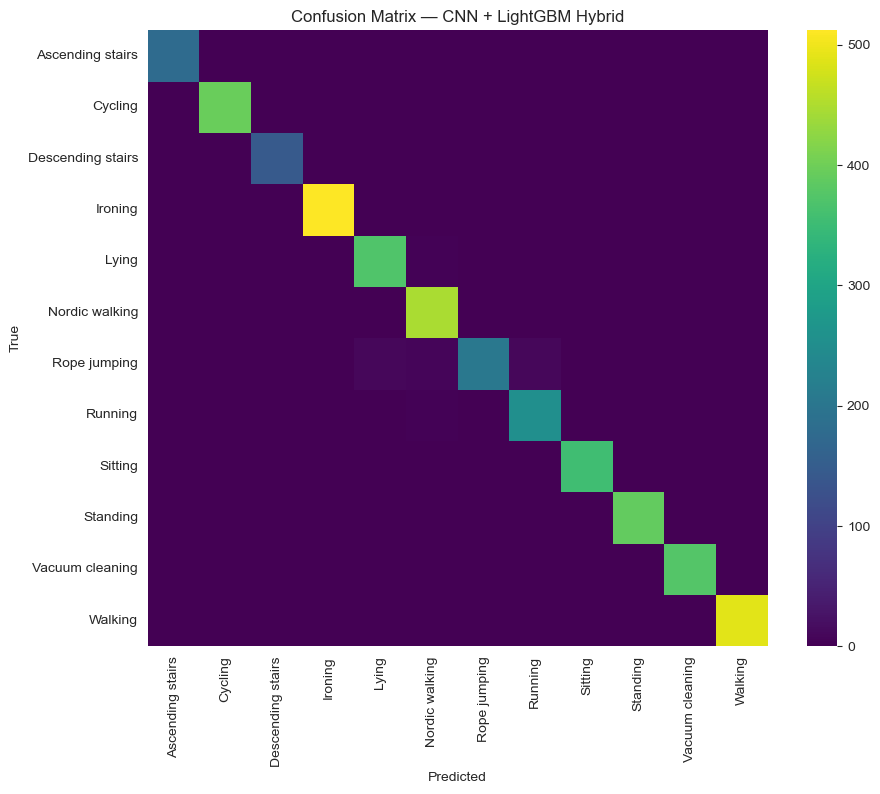

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_pred_hybrid)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="viridis", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — CNN + LightGBM Hybrid")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


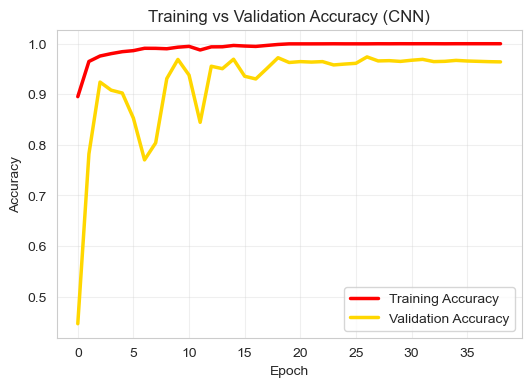

In [126]:
# -------------------------
# Plot CNN training vs validation accuracy
# -------------------------

plt.figure(figsize=(6,4))

# Plot training accuracy over epochs
plt.plot(
    history.history["accuracy"],
    label="Training Accuracy",
    color="red",
    linewidth=2.5
)

# Plot validation accuracy over epochs
plt.plot(
    history.history["val_accuracy"],
    label="Validation Accuracy",
    color="gold",
    linewidth=2.5
)

# Axis labels and title
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (CNN)")

# Legend and grid for readability
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()


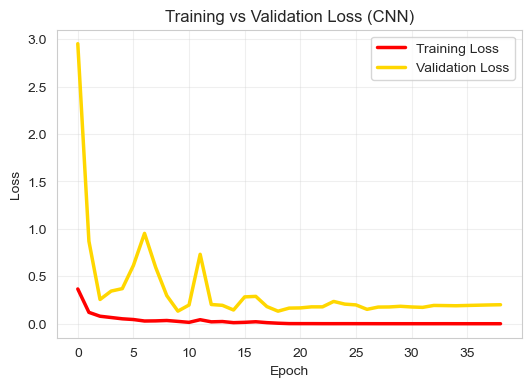

In [127]:
# Training vs Validation Loss

plt.figure(figsize=(6,4))

plt.plot(
    history.history["loss"],
    label="Training Loss",
    color="red",
    linewidth=2.5
)

plt.plot(
    history.history["val_loss"],
    label="Validation Loss",
    color="gold",
    linewidth=2.5
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CNN)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [138]:
import pandas as pd

final_results_df = pd.DataFrame({
    "Model": [
        "LightGBM (Engineered Features)",
        "Hybrid CNN → LightGBM"
    ],
    "Test Accuracy (%)": [
        99.41,
        99.27
    ],
    "Macro F1 (%)": [
        99.20,
        99.09
    ]
})

final_results_df


,Model,Test Accuracy (%),Macro F1 (%)
0,LightGBM (Engineered Features),99.41,99.20
1,Hybrid CNN → LightGBM,99.27,99.09


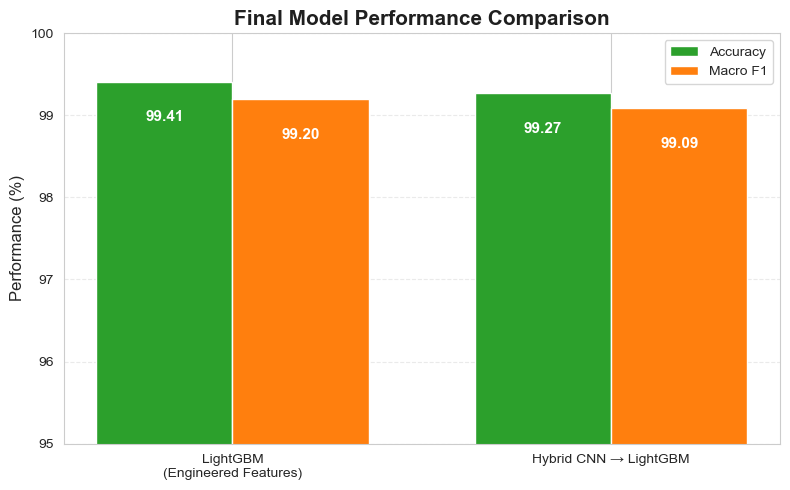

In [139]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "LightGBM\n(Engineered Features)",
    "Hybrid CNN → LightGBM"
]

accuracy = [99.41, 99.27]
macro_f1 = [99.20, 99.09]

x = np.arange(len(models))
width = 0.36

plt.figure(figsize=(8, 5))

bars1 = plt.bar(
    x - width/2,
    accuracy,
    width,
    label="Accuracy",
    color="#2ca02c"
)

bars2 = plt.bar(
    x + width/2,
    macro_f1,
    width,
    label="Macro F1",
    color="#ff7f0e"
)

# Value labels inside bars
for bar in bars1 + bars2:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h - 0.35,
        f"{h:.2f}",
        ha="center",
        va="top",
        fontsize=11,
        fontweight="bold",
        color="white"
    )

plt.ylim(95, 100)
plt.ylabel("Performance (%)", fontsize=12)
plt.xticks(x, models)
plt.title(
    "Final Model Performance Comparison",
    fontsize=15,
    fontweight="bold",
    color="#1f1f1f"
)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Radar Chart

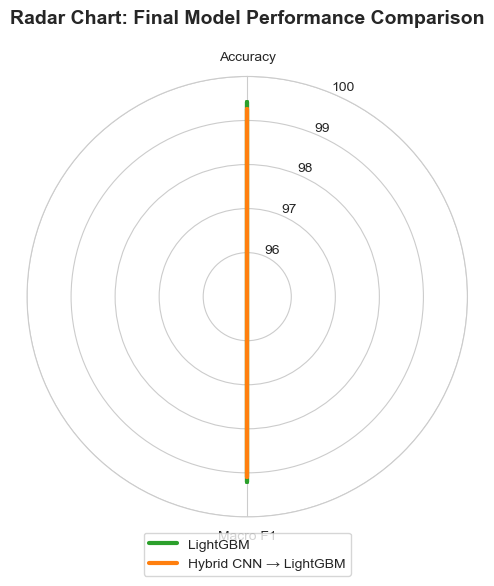

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Radar chart setup
# -------------------------

# Evaluation metric labels
labels = ["Accuracy", "Macro F1"]
num_vars = len(labels)

# -------------------------
# Model performance values (in %)
# -------------------------

# LightGBM performance
lightgbm = [99.41, 99.20]

# Hybrid CNN → LightGBM performance
hybrid   = [99.27, 99.09]

# Close the radar loop by repeating the first value
lightgbm += lightgbm[:1]
hybrid   += hybrid[:1]

# Compute angles for radar axes
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# -------------------------
# Create radar plot
# -------------------------

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# -------------------------
# Plot LightGBM performance
# -------------------------

ax.plot(
    angles,
    lightgbm,
    color="#2ca02c",
    linewidth=3,
    label="LightGBM"
)
ax.fill(
    angles,
    lightgbm,
    color="#2ca02c",
    alpha=0.25
)

# -------------------------
# Plot Hybrid model performance
# -------------------------

ax.plot(
    angles,
    hybrid,
    color="#ff7f0e",
    linewidth=3,
    label="Hybrid CNN → LightGBM"
)
ax.fill(
    angles,
    hybrid,
    color="#ff7f0e",
    alpha=0.25
)

# -------------------------
# Radar axis configuration
# -------------------------

# Start from top and rotate clockwise
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set metric labels on axes
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Set radial limits and ticks
ax.set_ylim(95, 100)
ax.set_yticks([96, 97, 98, 99, 100])
ax.set_yticklabels(["96", "97", "98", "99", "100"])

# -------------------------
# Title and legend
# -------------------------

plt.title(
    "Radar Chart: Final Model Performance Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20
)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1
)

# Adjust layout and display plot
plt.tight_layout()
plt.show()
